In [1]:
from mhr.utils.utils import process_jsonl
pope_object_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/benchmarks/analysis/pope/pope_object_rank.jsonl"
mme_object_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/benchmarks/analysis/mme/mme_object_rank.jsonl"
pope_co_occurrence_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/benchmarks/analysis/pope/pope_co_occurrence_rank.jsonl"
mme_co_occurrence_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/benchmarks/analysis/mme/mme_co_occurrence_rank.jsonl"
pope_token_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/benchmarks/analysis/pope/pope_token_rank.jsonl"
mme_token_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/benchmarks/analysis/mme/mme_token_rank.jsonl"
# raw_statistic_data = process_jsonl(statistic_file)

In [2]:
def detect_wrong_or_right(data_list):
    if isinstance(data_list,list):
        for item in data_list:
            if item["correct"] == False:
                return False
        return True
    elif isinstance(data_list,dict):
        if data_list["correct"] == True:
            return True
        else:
            return False

In [3]:
def get_pope_object_data(pope_object_file,granularity = 20,max_idx=None, min_idx=None):
    raw_statistic_data = process_jsonl(pope_object_file)
    right_dict = {}
    wrong_dict = {}
    for i in range(0,len(raw_statistic_data),6):
        if detect_wrong_or_right(raw_statistic_data[i:i+6]):
            for word_idx in raw_statistic_data[i]["rank_list"]:
                if word_idx not in right_dict:
                    right_dict[word_idx] = 1
                else:
                    right_dict[word_idx] += 1
        else:
            for word_idx in raw_statistic_data[i]["rank_list"]:
                if word_idx not in wrong_dict:
                    wrong_dict[word_idx] = 1
                else:
                    wrong_dict[word_idx] += 1

    max_idx = max(max(right_dict.keys()),max(wrong_dict.keys())) if max_idx is None else max_idx
    min_idx = min(min(right_dict.keys()),min(wrong_dict.keys())) if min_idx is None else min_idx
    # max_idx = 12500
    # min_idx = 0
    step = (max_idx - min_idx) // granularity
    return right_dict,wrong_dict,max_idx,min_idx,step

def get_mme_object_data(mme_object_file,granularity = 20,max_idx=None, min_idx=None):
    raw_statistic_data = process_jsonl(mme_object_file)
    right_dict = {}
    wrong_dict = {}
    for i in range(0,len(raw_statistic_data)):
        if detect_wrong_or_right(raw_statistic_data[i]):
            for word_idx in raw_statistic_data[i]["rank_list"]:
                if word_idx not in right_dict:
                    right_dict[word_idx] = 1
                else:
                    right_dict[word_idx] += 1
        else:
            for word_idx in raw_statistic_data[i]["rank_list"]:
                if word_idx not in wrong_dict:
                    wrong_dict[word_idx] = 1
                else:
                    wrong_dict[word_idx] += 1

    max_idx = max(max(right_dict.keys()),max(wrong_dict.keys())) if max_idx is None else max_idx
    min_idx = min(min(right_dict.keys()),min(wrong_dict.keys())) if min_idx is None else min_idx
    # max_idx = 12500
    # min_idx = 0
    step = (max_idx - min_idx) // granularity
    return right_dict,wrong_dict,max_idx,min_idx,step

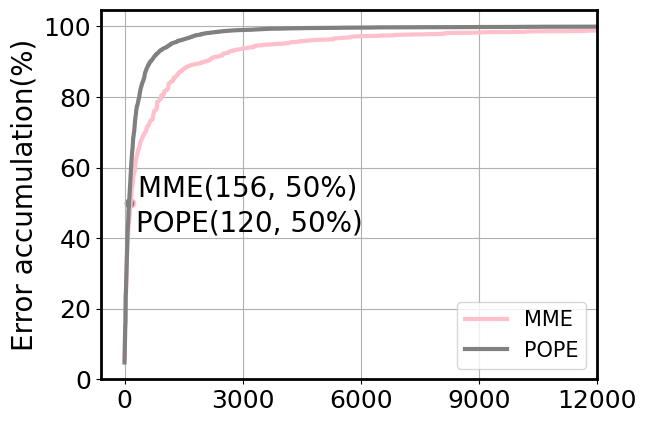

In [5]:
import matplotlib.pyplot as plt
_,mme_wrong_dict,mme_max_idx,mme_min_idx,mme_step = get_mme_object_data(mme_token_file,min_idx=0,granularity=50000)
_,pope_wrong_dict,pope_max_idx,pope_min_idx,pope_step = get_pope_object_data(pope_token_file,min_idx=0,granularity=50000)

min_idx = min(mme_min_idx,pope_min_idx)
max_idx = max(mme_max_idx,pope_max_idx)
step = (max_idx - min_idx) // 50000
bins = [i for i in range(min_idx,max_idx+1,step)]
mmetok_acc = 0
popetok_acc = 0
mmetok_ys=[]
popetok_ys=[]

for idx,bin in enumerate(bins):
    if idx == 0 :
        continue
    for i in range(bins[idx-1],bins[idx]):
        mmetok_acc += mme_wrong_dict.get(i,0)
        popetok_acc += pope_wrong_dict.get(i,0)
    mmetok_ys.append(mmetok_acc)
    popetok_ys.append(popetok_acc)
# mmetok_ys = [ (1-x/mmetok_acc)*100 for x in mmetok_ys]
# popetok_ys = [ (1-x/popetok_acc)*100 for x in popetok_ys]
mmetok_ys = [ (x/mmetok_acc)*100 for x in mmetok_ys]
popetok_ys = [ (x/popetok_acc)*100 for x in popetok_ys]
plt.plot(mmetok_ys, color="pink",linewidth=3,label="MME")
plt.plot(popetok_ys, color="grey",linewidth=3,label="POPE")
# plt.title("Co-occurrence Level Distribution")
plt.legend(loc='lower right',fontsize=15)
plt.xticks(ticks=range(0, len(bins)-1, 7500), labels=bins[1::7500])
plt.scatter(26, 50, color='pink')
plt.scatter(20, 50, color='grey')
plt.text(56, 52, 'MME(156, 50%)', ha='left',fontsize=20)
plt.text(50, 42, 'POPE(120, 50%)', ha='left',fontsize=20)
# plt.xlabel("$Q_r^T$",fontsize=20)
plt.ylabel("Error accumulation(%)",fontsize=20)
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_xlim([-100, 2000])
ax.set_xticks([0,500,1000,1500,2000])
ax.set_xticklabels([bins[0],bins[500],bins[1000],bins[1500],bins[2000]])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid(True)
plt.savefig('res/token_level_wrong_distribution.pdf', bbox_inches='tight')
plt.show()

In [21]:
for idx,x in enumerate(mmetok_ys):
    if x<=50:
        print(f"mme token threshold:{bins[idx]}; idx:{idx}  : {x}")
        mmetok_thres = bins[idx]
        break
for idx,x in enumerate(popetok_ys):
    if x<=50:
        print(f"pope token threshold:{bins[idx]}; idx:{idx}  : {x}")
        popetok_thres = bins[idx]
        break

mme token threshold:156; idx:26  : 49.49017657299179
pope token threshold:120; idx:20  : 49.230580840034285


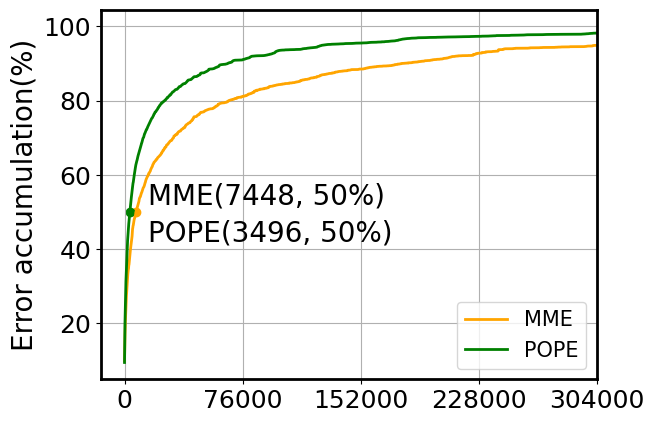

In [6]:
import matplotlib.pyplot as plt
# right_dict,wrong_dict,max_idx,min_idx,step = get_pope_object_data(pope_object_file)

# right_dict,wrong_dict,max_idx,min_idx,step = get_mme_object_data(mme_object_file,min_idx=1000,max_idx=12500)
_,mme_wrong_dict,mme_max_idx,mme_min_idx,mme_step = get_mme_object_data(mme_co_occurrence_file,min_idx=0,granularity=5000)
# _,mme_obj_wrong_dict,mme_obj_max_idx,mme_obj_min_idx,mme_obj_step = get_mme_object_data(mme_object_file,min_idx=0,granularity=1000)
_,pope_wrong_dict,pope_max_idx,pope_min_idx,pope_step = get_pope_object_data(pope_co_occurrence_file,min_idx=0,granularity=5000)
# _,pope_obj_wrong_dict,pope_obj_max_idx,pope_obj_min_idx,pope_obj_step = get_pope_object_data(pope_object_file,min_idx=0,granularity=1000)
# min_idx = min(mme_min_idx,mme_obj_min_idx,pope_min_idx,pope_obj_min_idx)
# max_idx = max(mme_max_idx,mme_obj_max_idx,pope_max_idx,pope_obj_max_idx)
min_idx = min(mme_min_idx,pope_min_idx)
max_idx = max(mme_max_idx,pope_max_idx)
step = (max_idx - min_idx) // 5000
bins = [i for i in range(min_idx,max_idx+1,step)]
mmeco_acc = 0
# mmeobj_acc = 0
popeco_acc = 0
# popeobj_acc = 0
mmeco_ys=[]
# mmeobj_ys=[]
popeco_ys=[]
# popeobj_ys=[]

for idx,bin in enumerate(bins):
    if idx == 0 :
        continue
    for i in range(bins[idx-1],bins[idx]):
        mmeco_acc += mme_wrong_dict.get(i,0)
        # mmeobj_acc += mme_obj_wrong_dict.get(i,0)
        popeco_acc += pope_wrong_dict.get(i,0)
        # popeobj_acc += pope_obj_wrong_dict.get(i,0)
    mmeco_ys.append(mmeco_acc)
    popeco_ys.append(popeco_acc)
mmeco_ys = [ x/mmeco_acc*100 for x in mmeco_ys]
popeco_ys = [ x/popeco_acc*100 for x in popeco_ys]
# plt.figure(size=(5,7))
# plt.bar(list(range(len(draw_ys))),draw_ys,width=0.8)
plt.plot(mmeco_ys, color="orange",linewidth=2.0,label="MME")
plt.plot(popeco_ys, color="green",linewidth=2.0,label="POPE")
# plt.title("Co-occurrence Level Distribution")
plt.legend(loc='lower right',fontsize=15)
plt.xticks(ticks=range(0, len(bins)-1, 750), labels=bins[1::750])
plt.scatter(49, 50, color='orange')
plt.scatter(23, 50, color='green')
plt.text(100, 52, 'MME(7448, 50%)', ha='left',fontsize=20)
plt.text(100, 42, 'POPE(3496, 50%)', ha='left',fontsize=20)
# plt.xlabel("$Q_r^C$",fontsize=20)
plt.ylabel("Error accumulation(%)",fontsize=20)
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim([-100, 2000])
ax.set_xticks([0,500,1000,1500,2000])
ax.set_xticklabels([bins[0],bins[500],bins[1000],bins[1500],bins[2000]])
plt.grid(True)
plt.savefig('res/co_occurrenc_level_wrong_distribution.pdf', bbox_inches='tight')
plt.show()






In [23]:
for idx,x in enumerate(mmeco_ys):
    if x<=50:
        print(f"mme co-occurrence threshold:{bins[idx]}; idx:{idx}  : {x}")
        mmeco_thres = bins[idx]
        break
for idx,x in enumerate(popeco_ys):
    if x<=50:
        print(f"pope co-occurrence threshold:{bins[idx]}; idx:{idx}  : {x}")
        popeco_thres = bins[idx]
        break
        

mme co-occurrence threshold:7448; idx:49  : 49.96473077827416
pope co-occurrence threshold:3496; idx:23  : 49.83121525019857


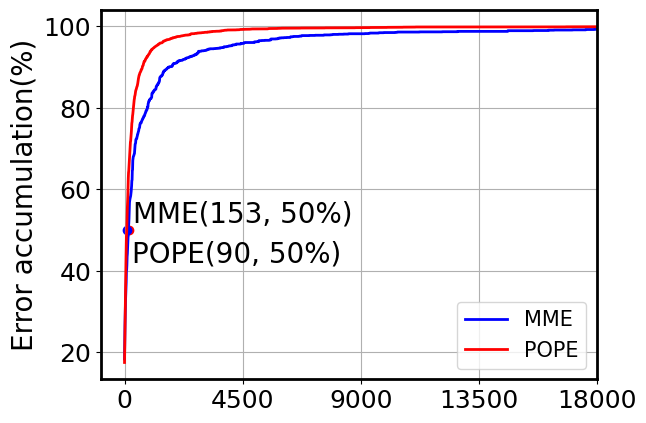

In [7]:
import matplotlib.pyplot as plt

_,mme_obj_wrong_dict,mme_obj_max_idx,mme_obj_min_idx,mme_obj_step = get_mme_object_data(mme_object_file,min_idx=0,granularity=5000)
_,pope_obj_wrong_dict,pope_obj_max_idx,pope_obj_min_idx,pope_obj_step = get_pope_object_data(pope_object_file,min_idx=0,granularity=5000)
min_idx = min(mme_obj_min_idx,pope_obj_min_idx)
max_idx = max(mme_obj_max_idx,pope_obj_max_idx)

step = (max_idx - min_idx) // 5000
bins = [i for i in range(min_idx,max_idx+1,step)]
mmeobj_acc = 0
popeobj_acc = 0

mmeobj_ys=[]
popeobj_ys=[]

for idx,bin in enumerate(bins):
    if idx == 0 :
        continue
    for i in range(bins[idx-1],bins[idx]):
        mmeobj_acc += mme_obj_wrong_dict.get(i,0)
        popeobj_acc += pope_obj_wrong_dict.get(i,0)
    mmeobj_ys.append(mmeobj_acc)
    popeobj_ys.append(popeobj_acc)
mmeobj_ys = [ (x/mmeobj_acc)*100 for x in mmeobj_ys]
popeobj_ys = [ (x/popeobj_acc)*100 for x in popeobj_ys]
# plt.figure(size=(5,7))
# plt.bar(list(range(len(draw_ys))),draw_ys,width=0.8)
# plt.plot(mmeco_ys, color="orange",linewidth=2.0,label="mme_co")
plt.plot(mmeobj_ys, color="blue",linewidth=2.0,label="MME")
# plt.plot(popeco_ys, color="green",linewidth=2.0,label="pope_co")
plt.plot(popeobj_ys, color="red",linewidth=2.0,label="POPE")
# plt.title("Object Level Distribution")
plt.legend(loc='lower right',fontsize=15)
plt.xticks(ticks=range(0, len(bins)-1, 750), labels=bins[1::750])
plt.scatter(17, 50, color='red')
plt.scatter(10, 50, color='blue')
plt.text(37, 52, 'MME(153, 50%)', ha='left',fontsize=20)
plt.text(30, 42, 'POPE(90, 50%)', ha='left',fontsize=20)
# plt.xlabel("$Q_r^O$",fontsize=20)
plt.ylabel("Error accumulation(%)",fontsize=20)
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_xlim([-100, 2000])
ax.set_xticks([0,500,1000,1500,2000])
plt.tick_params(axis='both', which='major', labelsize=18)
ax.set_xticklabels([bins[0],bins[500],bins[1000],bins[1500],bins[2000]])
plt.grid(True)
plt.savefig('res/object_level_wrong_distribution.pdf', bbox_inches='tight')


plt.show()

In [25]:
for idx,x in enumerate(mmeobj_ys):
    if x<=50:
        print(f"mme obj threshold:{bins[idx]}; idx:{idx} : {x}")
        mmeobj_thres = bins[idx]
        break
for idx,x in enumerate(popeobj_ys):
    if x<=50:
        print(f"pope obj threshold:{bins[idx]}; idx:{idx}  : {x}")
        popeobj_thres = bins[idx]
        break

mme obj threshold:153; idx:17 : 49.025300705101614
pope obj threshold:90; idx:10  : 48.93840655875552


In [27]:
from mhr.utils.utils import load_json_file, process_jsonl,write_jsonl
from py2neo import *
from neo4j import GraphDatabase
from tqdm import tqdm

def get_object_list_by_neo4j(database="instructmix665kllama"):
    uri = "neo4j://10.140.54.16:7687"
    driver = GraphDatabase.driver(uri, auth=("neo4j", "12345678"))
    query = "match (n) return n;"
    with driver.session(database=database) as session:
        results = session.run(query).data()
        results.sort(key=lambda x: x['n']['count'], reverse=True)
        
    return results

def get_co_occurrence_list_by_neo4j(database="instructmix665kllama"):
    uri = "neo4j://10.140.54.16:7687"
    driver = GraphDatabase.driver(uri, auth=("neo4j", "12345678"))
    query = "match (a)-[r:CO_OCCURRENCE]->(b) return a.lemma, r.count, b.lemma;"
    with driver.session(database=database) as session:
        results = session.run(query).data()
        results.sort(key=lambda x: x['r.count'], reverse=True)
        
    return results

def get_token_by_neo4j(database="instructmix665kpos"):
    uri = "neo4j://10.140.54.16:7687"
    driver = GraphDatabase.driver(uri, auth=("neo4j", "12345678"))
    query = "match (n) return n;"
    with driver.session(database=database) as session:
        results = session.run(query).data()
        results.sort(key=lambda x: x['n']['count'], reverse=True)
        
    return results

In [28]:

object_list = get_object_list_by_neo4j()
co_occurrence_list = get_co_occurrence_list_by_neo4j()
token_list = get_co_occurrence_list_by_neo4j()
len_of_obj = len(object_list)
len_of_co = len(co_occurrence_list)
len_of_tok = len(token_list)

In [29]:
# reverse index
token_input_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/LLaVA-Instruct-150K/reverse_index/llava_v1_5_mix665k_token_reverse_index.jsonl"
object_input_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/LLaVA-Instruct-150K/reverse_index/llava_v1_5_mix665k_dino_stat_reverse_index.jsonl"
co_occurrence_input_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/LLaVA-Instruct-150K/reverse_index/llava_v1_5_mix665k_co_occurrence_reverse_index.jsonl"
what_word_input_file="/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/LLaVA-Instruct-150K/reverse_index/llava_v1_5_mix665k_what_word_reverse_index.jsonl"

token_data = process_jsonl(token_input_file)
object_data = process_jsonl(object_input_file)
co_occurrence_data = process_jsonl(co_occurrence_input_file)
what_word_data = process_jsonl(what_word_input_file)

token_data.sort(key=lambda x: len(x["ids"]), reverse=True)
object_data.sort(key=lambda x: len(x["ids"]), reverse=True)
co_occurrence_data.sort(key=lambda x: len(x["ids"]), reverse=True)
what_word_data.sort(key=lambda x: len(x["ids"]), reverse=True)

token_data = [(x["object"],len(x["ids"])) for x in token_data]
object_data = [(x["object"],len(x["ids"])) for x in object_data]
co_occurrence_data = [(x["object"],len(x["ids"])) for x in co_occurrence_data]
what_word_data = [(x["object"],len(x["ids"])) for x in what_word_data]

token_sum = sum([x[1] for x in token_data])
object_sum = sum([x[1] for x in object_data])
co_occurrence_sum = sum([x[1] for x in co_occurrence_data])
what_word_sum = sum([x[1] for x in what_word_data])

token_dict = {x[0]:x[1] for x in token_data}
object_dict = {x[0]:x[1] for x in object_data}
co_occurrence_dict = {x[0]:x[1] for x in co_occurrence_data}
what_word_dict = {x[0]:x[1] for x in what_word_data}

In [30]:
popeco_acc = 0
mmeco_acc = 0
popeobj_acc = 0
mmeobj_acc = 0
pope_tok_acc = 0
mme_tok_acc = 0

for i in range(0,popeco_thres):
    popeco_acc += co_occurrence_dict.get(f"{co_occurrence_list[i]['a.lemma']},{co_occurrence_list[i]['b.lemma']}",0)
for i in range(0,mmeco_thres):
    mmeco_acc += co_occurrence_dict.get(f"{co_occurrence_list[i]['a.lemma']},{co_occurrence_list[i]['b.lemma']}",0)
for i in range(0,popeobj_thres):
    popeobj_acc += object_dict.get(object_list[i]['n']['lemma'],0)
for i in range(0,mmeobj_thres):
    mmeobj_acc += object_dict.get(object_list[i]['n']['lemma'],0)
for i in range(0,popetok_thres):
    pope_tok_acc += token_dict.get(token_list[i]['a.lemma'],0)
for i in range(0,mmetok_thres):
    mme_tok_acc += token_dict.get(token_list[i]['a.lemma'],0)

popeco_left = co_occurrence_sum - popeco_acc
mmeco_left = co_occurrence_sum - mmeco_acc
popeobj_left = object_sum - popeobj_acc
mmeobj_left = object_sum - mmeobj_acc
popetok_left = token_sum - pope_tok_acc
mmetok_left = token_sum - mme_tok_acc

res=f"POPE Co-occurrence: {popeco_left}/{co_occurrence_sum}({popeco_left/co_occurrence_sum*100:.2f}%) \n"
res+=f"MME Co-occurrence: {mmeco_left}/{co_occurrence_sum}({mmeco_left/co_occurrence_sum*100:.2f}%) \n"
res+=f"POPE Object: {popeobj_left}/{object_sum}({popeobj_left/object_sum*100:.2f}%) \n"
res+=f"MME Object: {mmeobj_left}/{object_sum}({mmeobj_left/object_sum*100:.2f}%) \n"
res+=f"POPE Token: {popetok_left}/{token_sum}({popetok_left/token_sum*100:.2f}%) \n"
res+=f"MME Token: {mmetok_left}/{token_sum}({mmetok_left/token_sum*100:.2f}%) \n"
print(res)

POPE Co-occurrence: 15748792/20873397(75.45%) 
MME Co-occurrence: 14531465/20873397(69.62%) 
POPE Object: 8058011/13484390(59.76%) 
MME Object: 6921376/13484390(51.33%) 
POPE Token: 12528882/15563718(80.50%) 
MME Token: 11708227/15563718(75.23%) 



In [31]:
popeco_thres_left = len_of_co - popeco_thres
mmeco_thres_left = len_of_co - mmeco_thres
popeobj_thres_left = len_of_obj - popeobj_thres
mmeobj_thres_left = len_of_obj - mmeobj_thres
popetok_thres_left = len_of_tok - popetok_thres
mmetok_thres_left = len_of_tok - mmetok_thres

res = f"POPE Co-occurrence: {popeco_thres_left}/{len_of_co}({popeco_thres_left/len_of_co*100:.2f}%) \n"
res+=f"MME Co-occurrence: {mmeco_thres_left}/{len_of_co}({mmeco_thres_left/len_of_co*100:.2f}%) \n"
res+=f"POPE Object: {popeobj_thres_left}/{len_of_obj}({popeobj_thres_left/len_of_obj*100:.2f}%) \n"
res+=f"MME Object: {mmeobj_thres_left}/{len_of_obj}({mmeobj_thres_left/len_of_obj*100:.2f}%) \n"
res+=f"POPE Token: {popetok_thres_left}/{len_of_tok}({popetok_thres_left/len_of_tok*100:.2f}%) \n"
res+=f"MME Token: {mmetok_thres_left}/{len_of_tok}({mmetok_thres_left/len_of_tok*100:.2f}%) \n"
print(res)

POPE Co-occurrence: 758907/762403(99.54%) 
MME Co-occurrence: 754955/762403(99.02%) 
POPE Object: 52589/52679(99.83%) 
MME Object: 52526/52679(99.71%) 
POPE Token: 762283/762403(99.98%) 
MME Token: 762247/762403(99.98%) 

